In [1]:
!pip install mxnet-cu100mkl

#MXNet

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

print('ctx:', ctx)

ctx: gpu(0)


##Getting the dataset

In [0]:
def transform(features, labels):
    return features.transpose((2, 0, 1)).astype('float32')/255.0, labels.astype('float32')

true_data = gluon.data.vision.MNIST(train = True, transform = transform)

image.shape: (1, 28, 28)
label 5.0


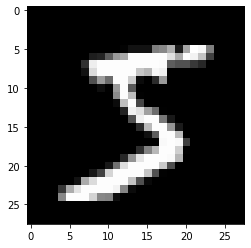

In [4]:
image, label = true_data[0]

print('image.shape:', image.shape)
print('label', label)

plt.imshow(image[0].asnumpy(), 'gray')
plt.show()

##Defining Dataloaders

In [5]:
batch_size = 64
train_data = gluon.data.DataLoader(true_data, batch_size = batch_size, shuffle = True)

print(f'No of Batches in training data: {len(train_data)}')

No of Batches in training data: 938


##Building Discriminator and Generator

In [6]:
class Discriminator(nn.HybridBlock):
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.name_scope():
            self.inputs = nn.HybridSequential()
            self.inputs.add(nn.Conv2D(64, 3, 1))
            self.inputs.add(nn.BatchNorm())
            self.inputs.add(nn.LeakyReLU(0.2))
            self.inputs.add(nn.AvgPool2D())

            self.labels = nn.HybridSequential()
            self.labels.add(nn.Dense(64 * 13 * 13))
            self.labels.add(nn.BatchNorm())
            self.labels.add(nn.LeakyReLU(0.2))
            self.labels.add(nn.HybridLambda(lambda F, x: x.reshape((-1, 64, 13, 13))))

            self.model = nn.HybridSequential()
            self.model.add(nn.Conv2D(128, 3, 1))
            self.model.add(nn.BatchNorm())
            self.model.add(nn.LeakyReLU(0.2))
            self.model.add(nn.AvgPool2D())
            self.model.add(nn.Flatten())
            self.model.add(nn.Dense(256))
            self.model.add(nn.BatchNorm())
            self.model.add(nn.LeakyReLU(0.2))
            self.model.add(nn.Dense(10, 'sigmoid'))

    def hybrid_forward(self, F, x, y):
        x = self.inputs(x)
        y = self.labels(y.expand_dims(2).expand_dims(2))
        outputs = self.model(F.concat(x, y, dim = 1))
        return outputs


class Generator(nn.HybridBlock):
    def __init__(self):
        super(Generator, self).__init__()
        with self.name_scope():
            self.model = nn.HybridSequential()
            self.model.add(nn.Dense(128 * 4 * 4))
            self.model.add(nn.BatchNorm())
            self.model.add(nn.Activation('sigmoid'))
            self.model.add(nn.HybridLambda(lambda F, x: x.reshape((-1, 128, 4, 4))))
            self.model.add(nn.Conv2DTranspose(64, 4, 1, 0))
            self.model.add(nn.BatchNorm())
            self.model.add(nn.Activation('sigmoid'))
            self.model.add(nn.Conv2DTranspose(32, 4, 2, 1))
            self.model.add(nn.BatchNorm())
            self.model.add(nn.Activation('sigmoid'))
            self.model.add(nn.Conv2DTranspose(1, 4, 2, 1, activation = 'sigmoid'))
    
    def hybrid_forward(self, F, y, z):
        y = y.expand_dims(2).expand_dims(2)
        z = z.expand_dims(2).expand_dims(2)
        outputs = self.model(F.concat(z, y, dim = 1))
        return outputs


discriminator = Discriminator()
discriminator.initialize(ctx = ctx, init = mx.init.Uniform())
discriminator.hybridize()

generator = Generator()
generator.initialize(ctx = ctx, init = mx.init.Uniform())
generator.hybridize()

print(discriminator)
print(generator)

Discriminator(
  (inputs): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): LeakyReLU(0.2)
    (3): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
  )
  (labels): HybridSequential(
    (0): Dense(None -> 10816, linear)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): LeakyReLU(0.2)
    (3): HybridLambda(<lambda>)
  )
  (model): HybridSequential(
    (0): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): LeakyReLU(0.2)
    (3): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
    (4): Flatten
    (5): Dense(

## Checking output shapes

In [7]:
x = nd.random.normal(0, 1, (1, 1, 28, 28), ctx = ctx)
y = nd.random.normal(0, 1, (1, 10), ctx = ctx)
z = nd.random.normal(0, 1, (1, 100), ctx = ctx)

generated = generator(y, z)
true = discriminator(x, y)

true.shape, generated.shape

((1, 10), (1, 1, 28, 28))

##Objective Losses

In [0]:
def discriminator_loss(true, false):
    return -nd.mean(nd.log(true) + nd.log(1 - false))

def generator_loss(false):
    return -nd.mean(nd.log(false))

## Defining Optimizers

In [0]:
generator_optimizer = mx.optimizer.Adam(0.001)
discriminator_optimizer = mx.optimizer.Adam(0.001)

generator_trainer = gluon.Trainer(generator.collect_params(), generator_optimizer)
discriminator_trainer = gluon.Trainer(discriminator.collect_params(), discriminator_optimizer)

## Training the model

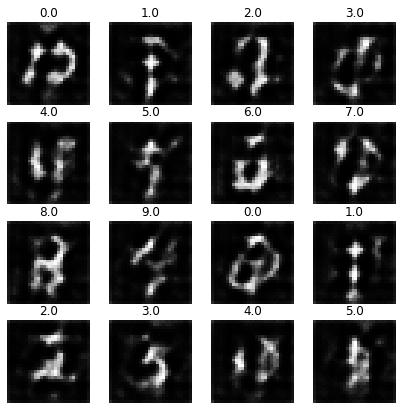

Batch: 300


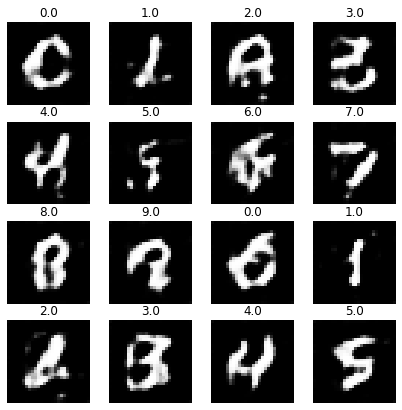

Batch: 600


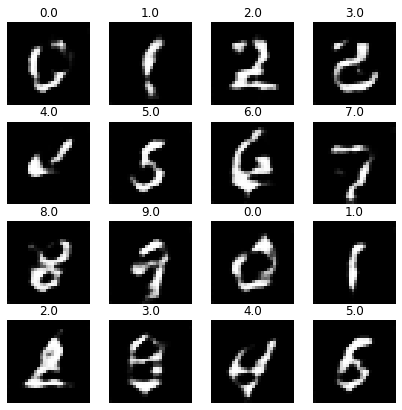

Batch: 900

Epoch: 1
Generator Loss: 2.7525
Discriminator Loss: 0.31342


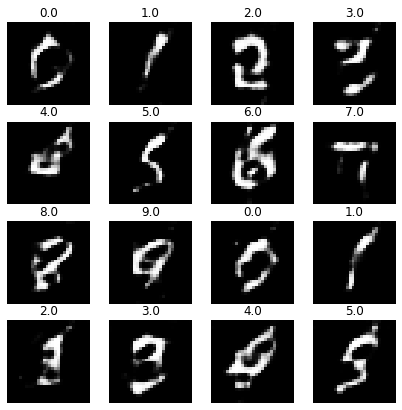

Batch: 300


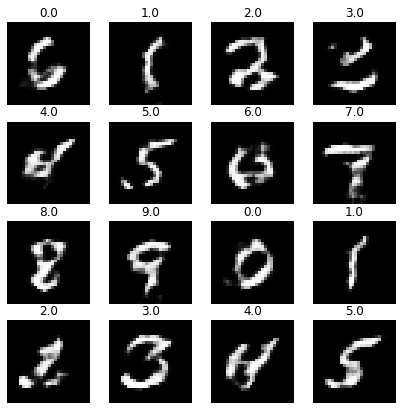

Batch: 600


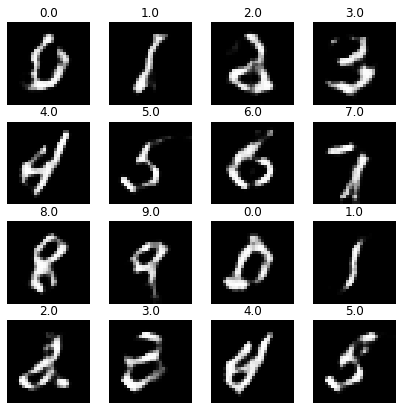

Batch: 900

Epoch: 2
Generator Loss: 3.6726
Discriminator Loss: 0.19877


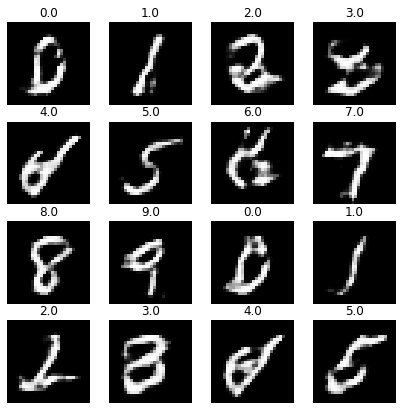

Batch: 300


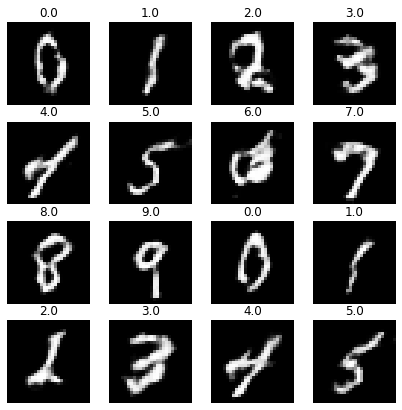

Batch: 600


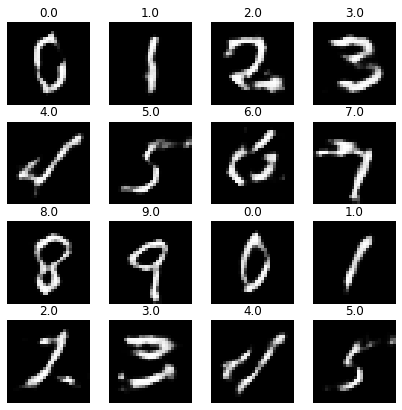

Batch: 900

Epoch: 3
Generator Loss: 3.1197
Discriminator Loss: 0.37472


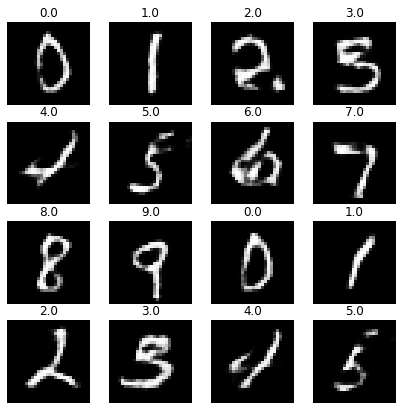

Batch: 300


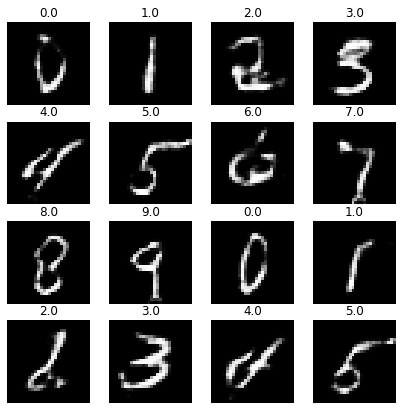

Batch: 600


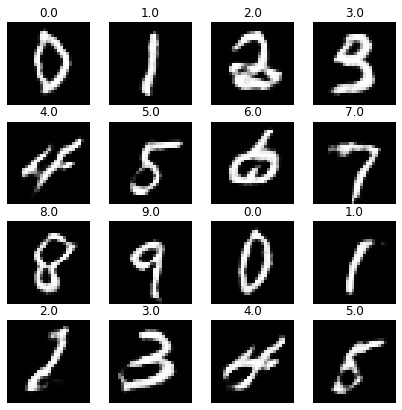

Batch: 900

Epoch: 4
Generator Loss: 2.8008
Discriminator Loss: 0.42770


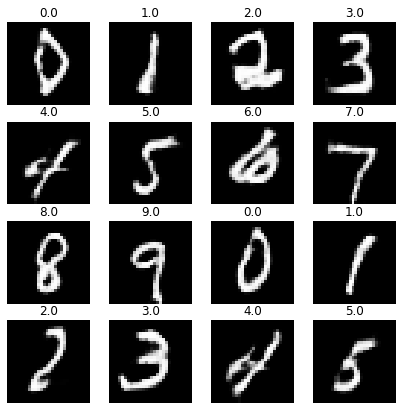

Batch: 300


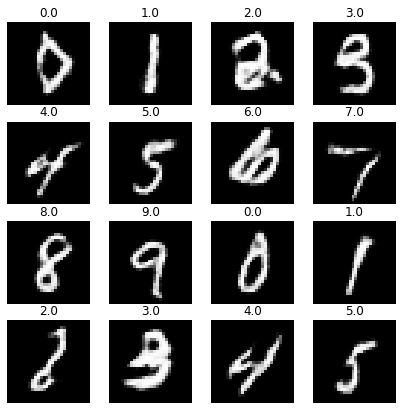

Batch: 600


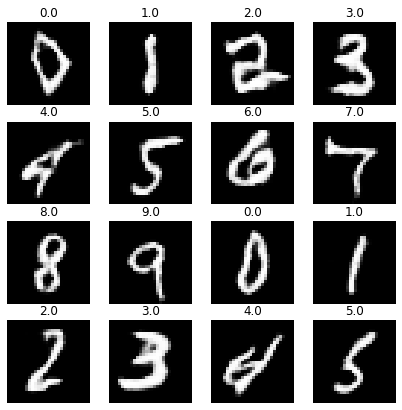

Batch: 900

Epoch: 5
Generator Loss: 2.8858
Discriminator Loss: 0.43419


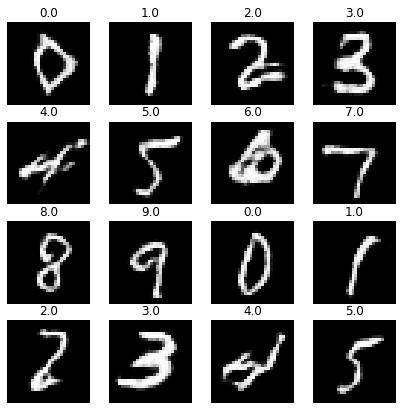

Batch: 300


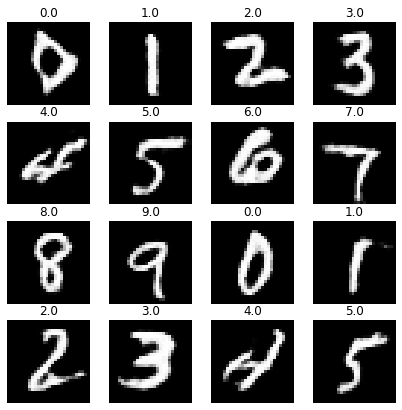

Batch: 600


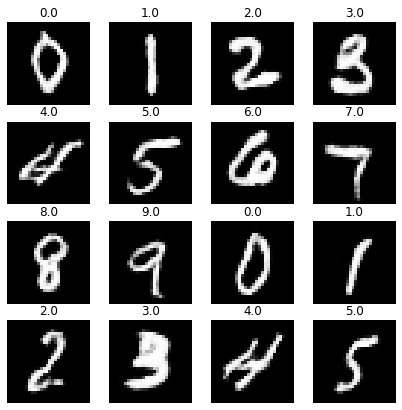

Batch: 900

Epoch: 6
Generator Loss: 2.8601
Discriminator Loss: 0.45016


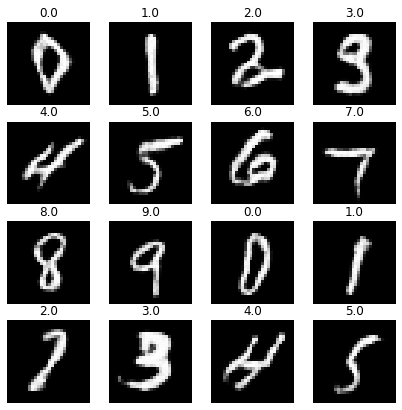

Batch: 300


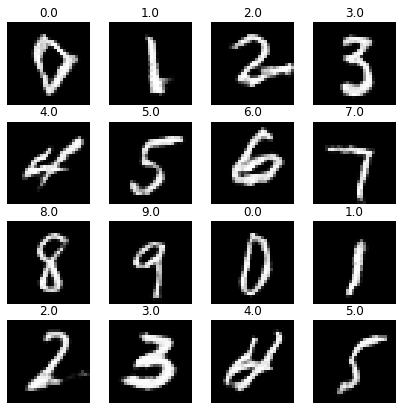

Batch: 600


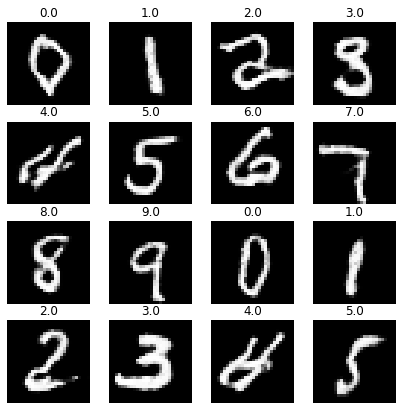

Batch: 900

Epoch: 7
Generator Loss: 2.8665
Discriminator Loss: 0.46149


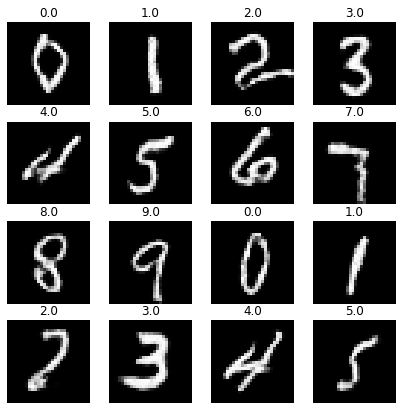

Batch: 300


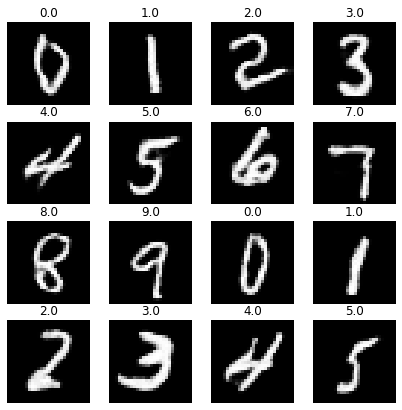

Batch: 600


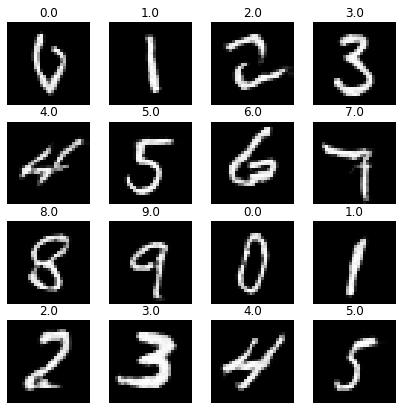

Batch: 900

Epoch: 8
Generator Loss: 2.8118
Discriminator Loss: 0.48328


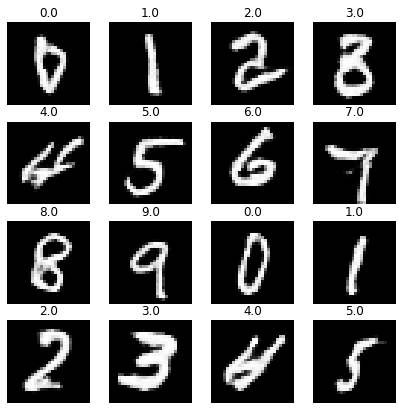

Batch: 300


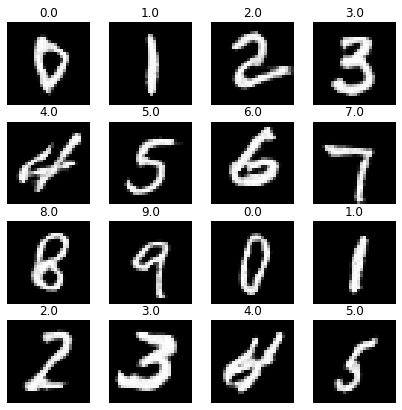

Batch: 600


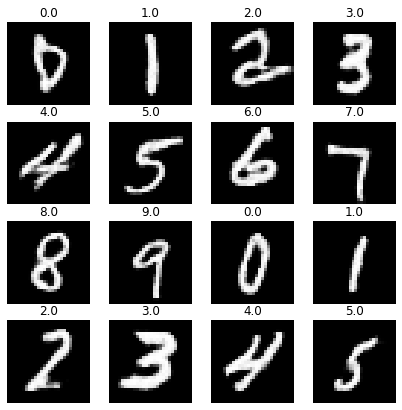

Batch: 900

Epoch: 9
Generator Loss: 2.7956
Discriminator Loss: 0.49220


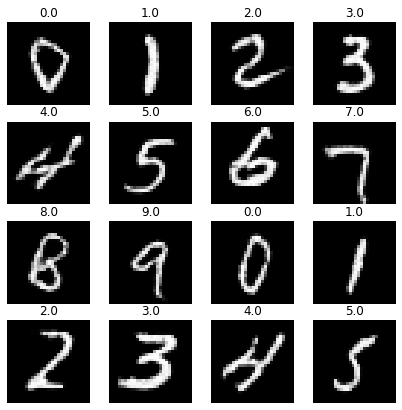

Batch: 300


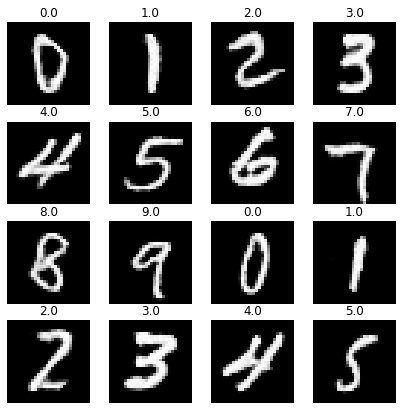

Batch: 600


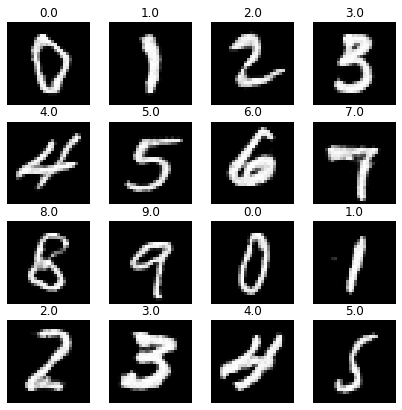

Batch: 900

Epoch: 10
Generator Loss: 2.8945
Discriminator Loss: 0.44934


In [10]:
epochs = 10

Dlosses = []
Glosses = []

y = nd.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5]).one_hot(10).as_in_context(ctx)
z = nd.random.normal(loc = 0, scale = 1, shape = (y.shape[0], 100)).as_in_context(ctx)

for epoch in range(epochs):
    dcum_loss = 0.0
    gcum_loss = 0.0

    for i, (features, labels),  in enumerate(train_data):
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx).one_hot(10)
        noise = nd.random.normal(0, 1, (features.shape[0], 100), ctx = ctx)

        with autograd.record():
            true = discriminator(features, labels)
            generated = generator(labels, noise)
            false = discriminator(generated, labels)
            d_loss = discriminator_loss(true, false)
        d_loss.backward()
        discriminator_trainer.step(batch_size)
        
        with autograd.record():
            generated = generator(labels, noise)
            false = discriminator(generated, labels)
            g_loss = generator_loss(false)
        g_loss.backward()
        generator_trainer.step(batch_size)
        
        dcum_loss += d_loss
        gcum_loss += g_loss

        if (i + 1) % 300 == 0:
            Dloss = dcum_loss.asscalar()/(i + 1)
            Gloss = gcum_loss.asscalar()/(i + 1)
            
            Dlosses.append(Dloss)
            Glosses.append(Gloss)

            plt.figure(figsize = (7, 7))
            generated = generator(y, z)
            for j, gen in enumerate(generated):
                plt.subplot(4, 4, j + 1)
                plt.imshow(gen[0, :, :].asnumpy(), 'gray')
                plt.axis('off')
                plt.title(y[j].argmax(0).asscalar())
            plt.show()
            print(f'Batch: {i + 1}')

    print(f'\nEpoch: {epoch + 1}')
    print(f'Generator Loss: {Gloss:.5}')
    print(f'Discriminator Loss: {Dloss:.5f}')

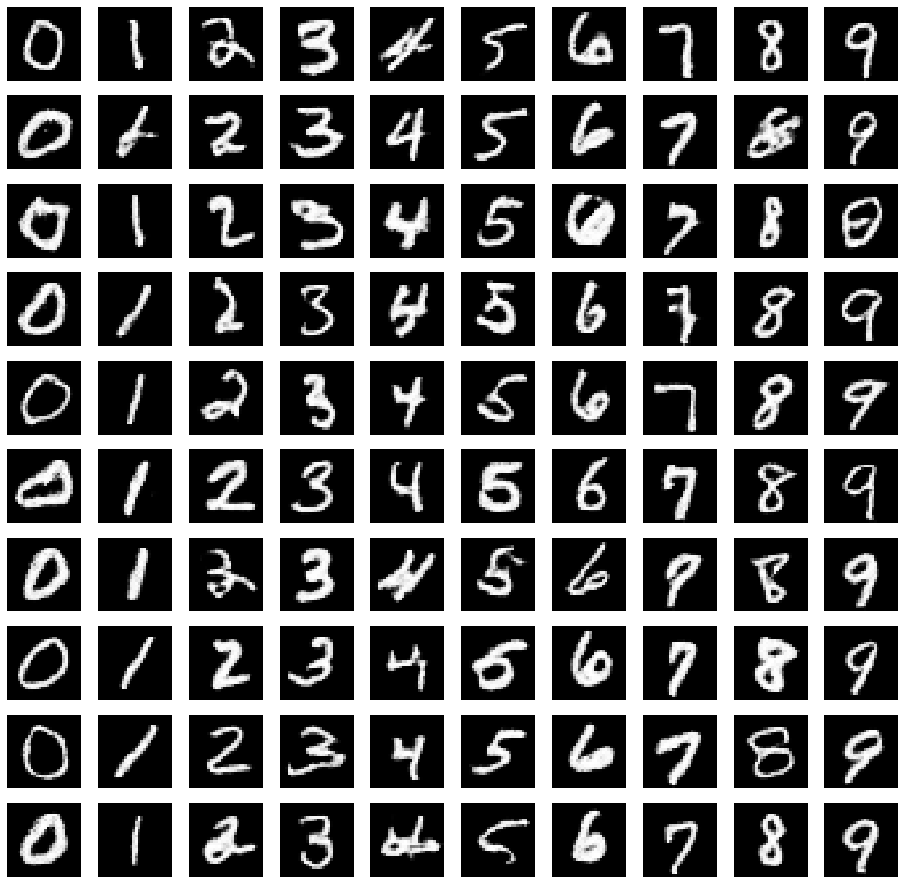

In [11]:
labels = nd.arange(0, 10, 1).tile(10).one_hot(10).as_in_context(ctx)
noise = nd.random.normal(0, 1, (100, 100)).as_in_context(ctx)

generated = generator(labels, noise)

plt.figure(figsize = (16, 16))
for i, image in enumerate(generated):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image[0, :, :].asnumpy(), 'gray')
    plt.axis('off')
plt.show()

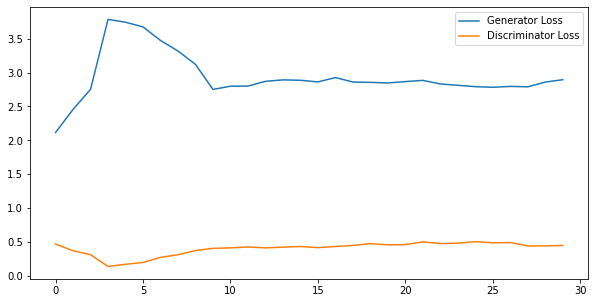

In [13]:
plt.figure(figsize = (10, 5))
plt.plot(Glosses, label = 'Generator Loss')
plt.plot(Dlosses, label = 'Discriminator Loss')
plt.legend()
plt.show()